In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [3]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

g_trends = pd.read_csv("../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

g_trends2 = pd.read_csv("../data generators/generated_trends_data/coinbase_daily.csv")
g_trends2 = g_trends2[['keyword','day','trend']]
g_trends2.index = g_trends2['day']
g_trends2 = g_trends2[(g_trends2['day'] >= start_date) & (g_trends2['day'] <= finish_date)]

w_pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

### Feature Extraction
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.concatenate((features,d))
    return features[1:,:]

preds = dict()
window_len_list = [14,21,30,120,365]
for window_len in window_len_list:
    print('window_len',window_len)
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    features_small = price_features
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)
    classes.shape

    ### Model Training & Hyperparameter Tuning

    features_dict = {'all':features,'price':features_small}
    for features_k in features_dict.keys():
        print('features',features_k)
        features = features_dict[features_k]
        train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
        x_train = features[:train_len,:]
        y_train = classes[:train_len,:]

        x_test = features[train_len:,:]
        y_test = classes[train_len:,:]

        random_grid = {'n_estimators': [25,50,100,200],
                       'learning_rate': [0.01,0.05,0.1,0.2],
                       'max_depth': [3,5,10,20],
                       #'min_samples_split': [5,10,20],
                       #'min_samples_leaf': [1,5,10] 
                      }

        gb = GradientBoostingClassifier()
        gb_random = RandomizedSearchCV(estimator = gb, 
                                       param_distributions = random_grid, 
                                       n_iter = 50, 
                                       cv = 4, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
        #Fit the random search model
        gb_random.fit(x_train, y_train)

        model = GradientBoostingClassifier(n_estimators=gb_random.best_params_['n_estimators'],
                                           learning_rate=gb_random.best_params_['learning_rate'],
                                           max_depth=gb_random.best_params_['max_depth'])
        model.fit(x_train,y_train)

        print('\ttraining score:',model.score(x_train, y_train))
        print('\ttest score:',model.score(x_test,y_test))
        
        preds['gb_w'+str(window_len)+'_feature_'+features_k] = model.predict(x_test)[1:]

window_len 14
features all
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


	training score: 0.5622406639004149
	test score: 0.5644028103044496
features price
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   49.3s finished


	training score: 0.6542185338865837
	test score: 0.5480093676814989
window_len 21
features all
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


	training score: 0.5545517720639332
	test score: 0.5690866510538641
features price
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


	training score: 0.6768589298123697
	test score: 0.5573770491803278
window_len 30
features all
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


	training score: 0.6293706293706294
	test score: 0.5690866510538641
features price
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


	training score: 0.6958041958041958
	test score: 0.5480093676814989
window_len 120
features all
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 20.2min finished


	training score: 0.5671641791044776
	test score: 0.5690866510538641
features price
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


	training score: 0.5798507462686567
	test score: 0.5573770491803278
window_len 365
features all
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 41.9min finished


	training score: 0.5789954337899543
	test score: 0.5714285714285714
features price
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.5min finished


	training score: 0.5643835616438356
	test score: 0.5690866510538641


In [11]:
preds.keys()

dict_keys(['gb_w14_feature_all', 'gb_w14_feature_price', 'gb_w21_feature_all', 'gb_w21_feature_price', 'gb_w30_feature_all', 'gb_w30_feature_price', 'gb_w120_feature_all', 'gb_w120_feature_price', 'gb_w365_feature_all', 'gb_w365_feature_price'])

## Momentum with Gradient Boosting

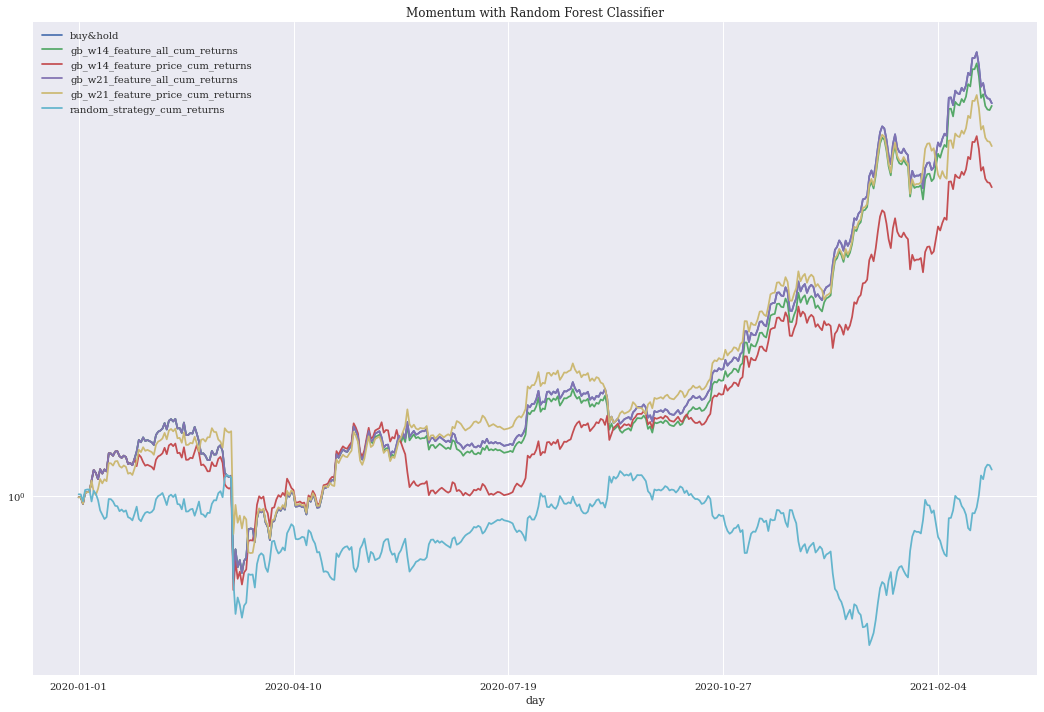

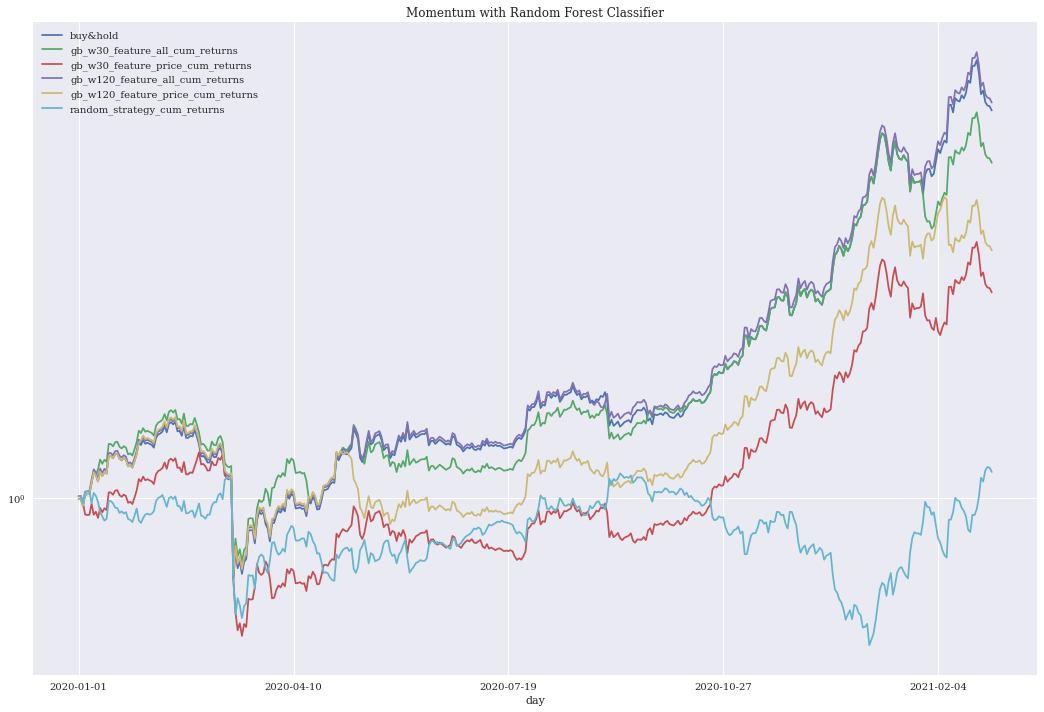

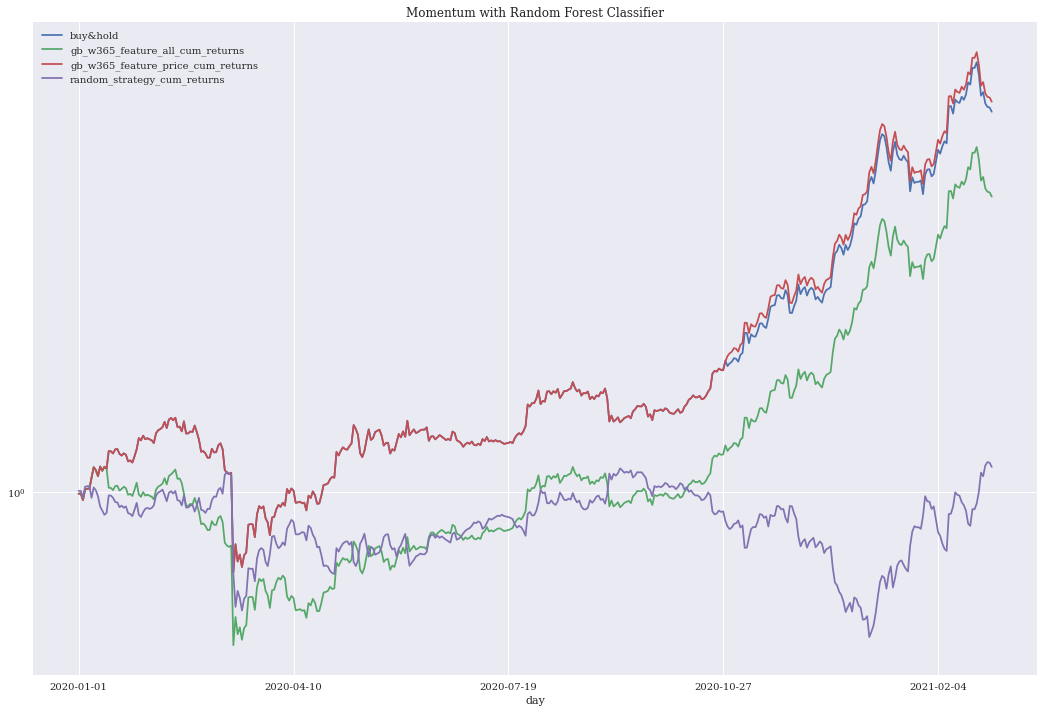

In [12]:
#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()


#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp] * test_data['returns']
test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()
    
plot_title = "Momentum with Random Forest Classifier"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:4]+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_columns2 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][4:-2]+['random_strategy_cum_returns']
ax = returns_data[plot_columns2].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_columns3 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][-2:]+['random_strategy_cum_returns']
ax = returns_data[plot_columns3].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

### Visualizing Positions

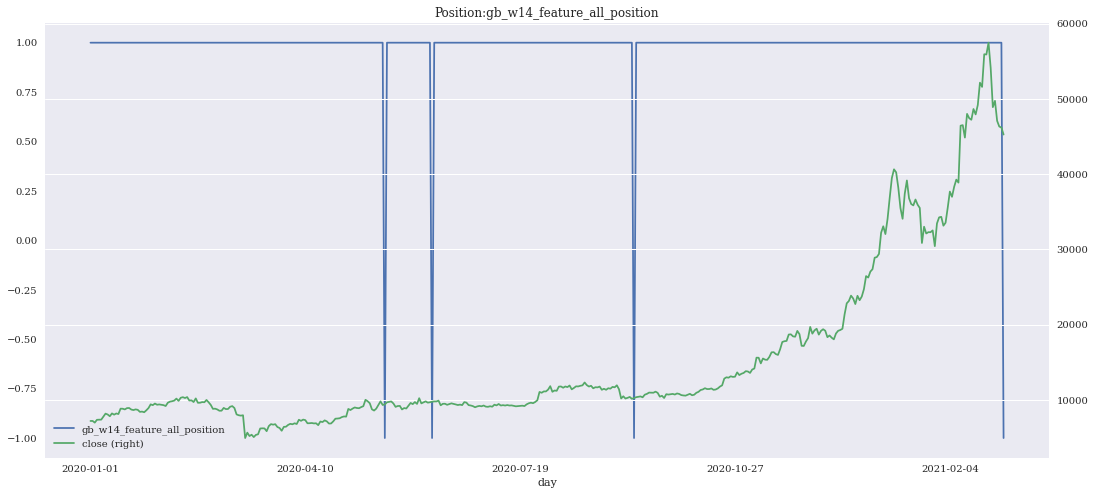

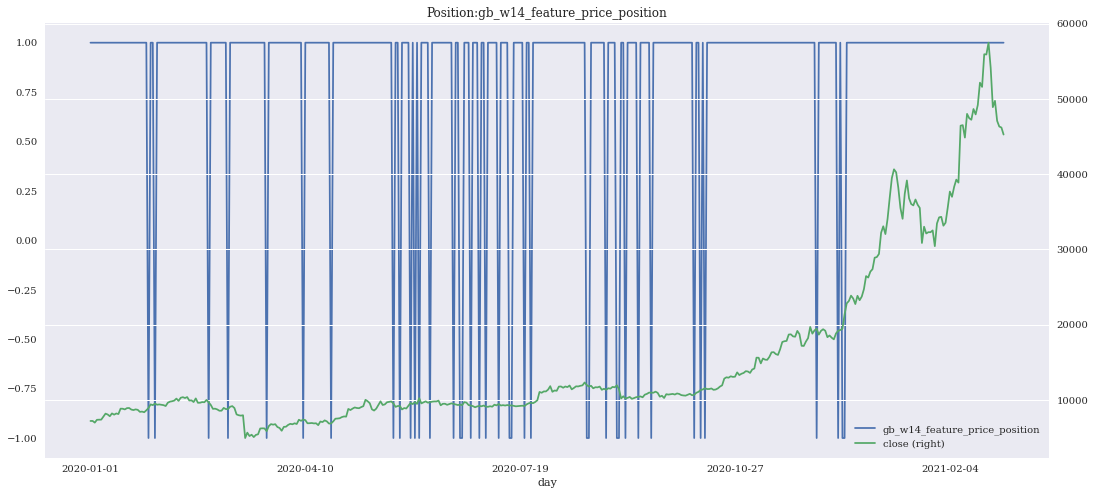

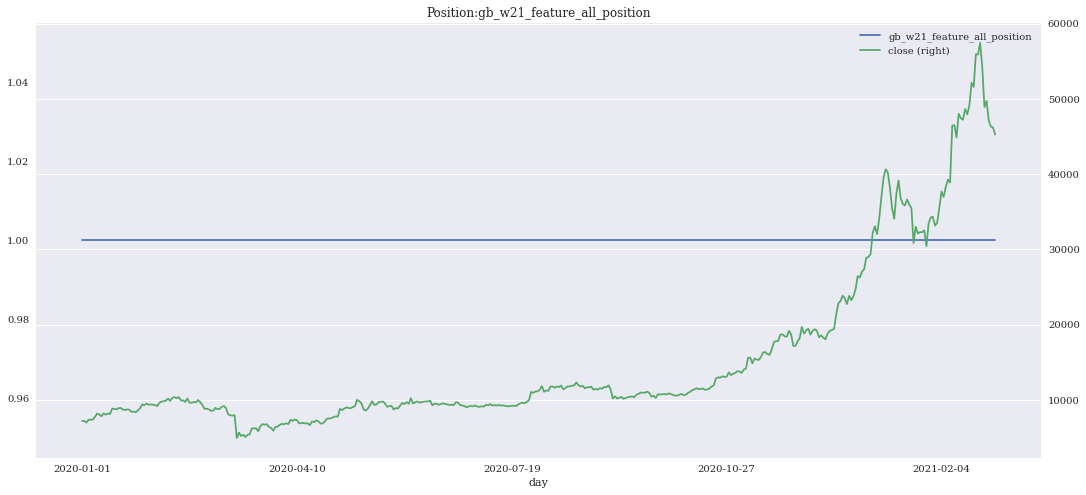

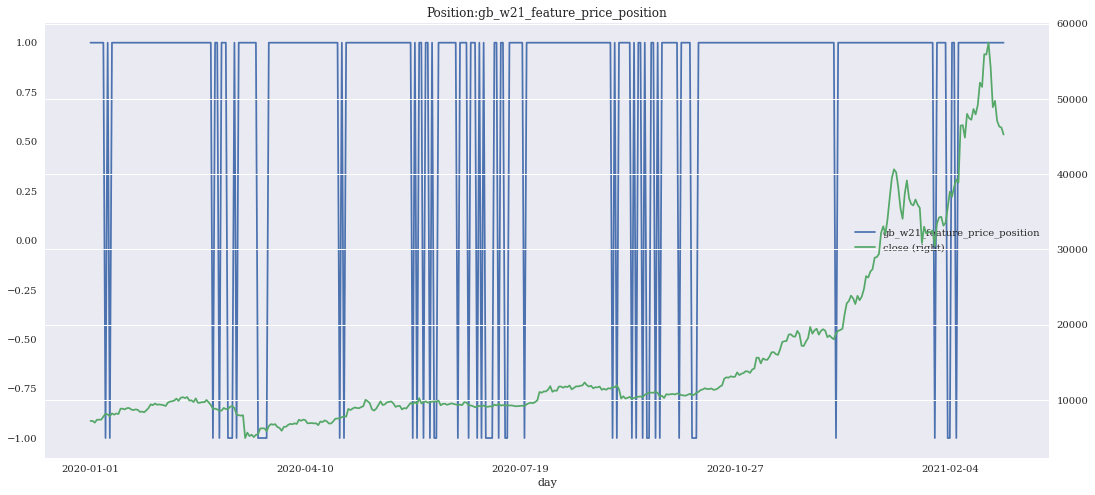

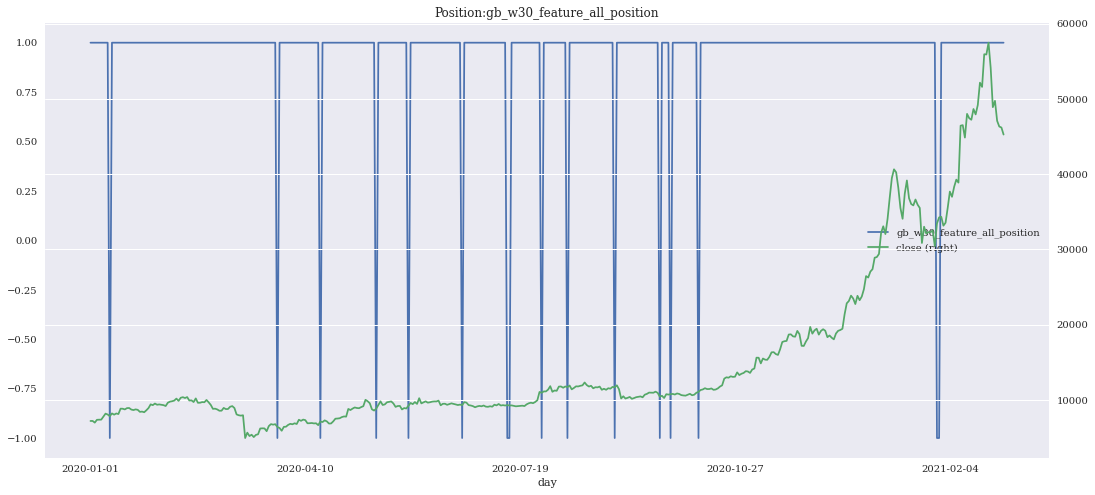

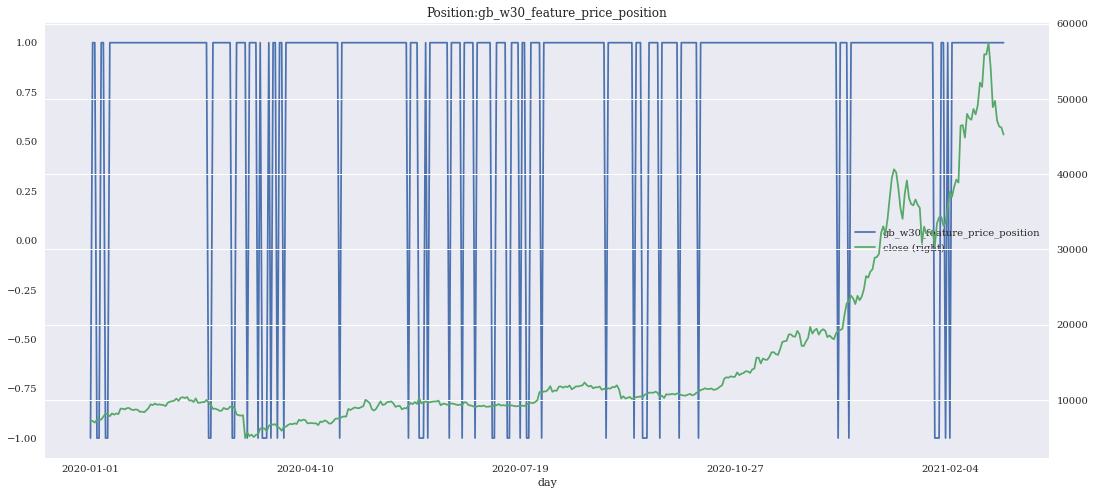

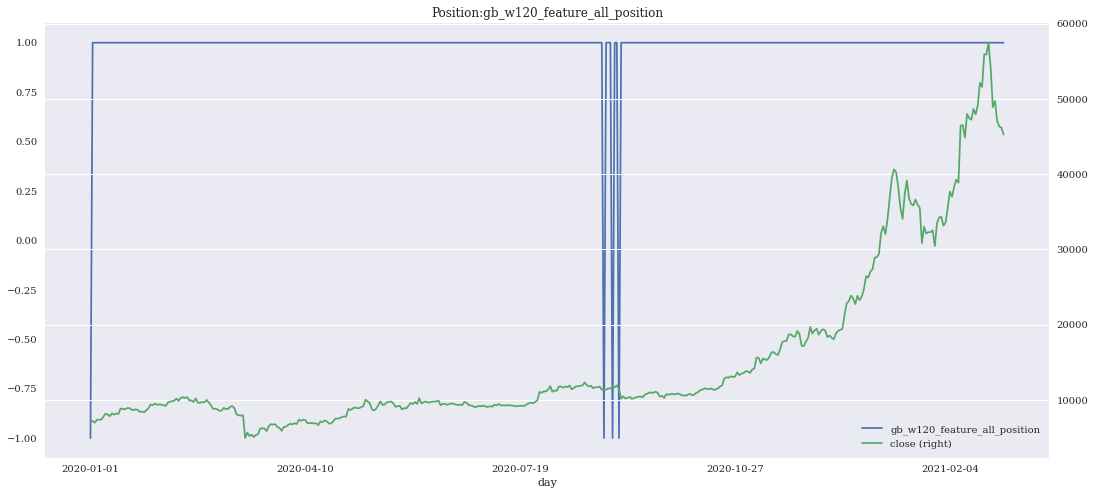

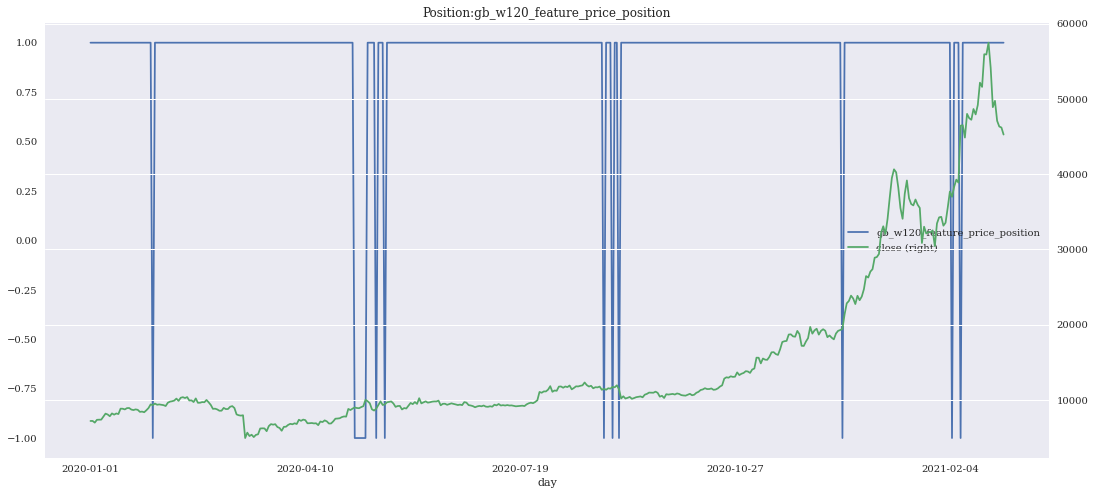

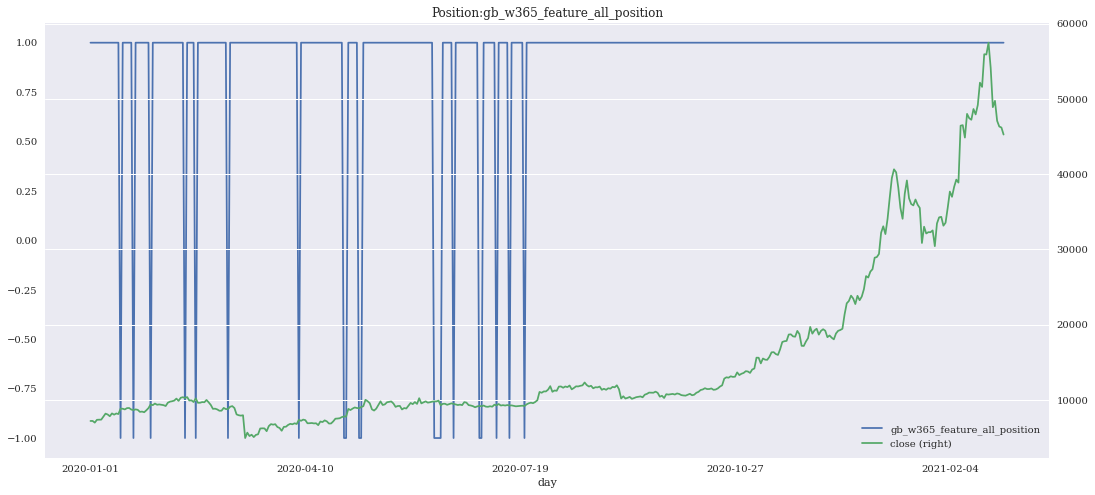

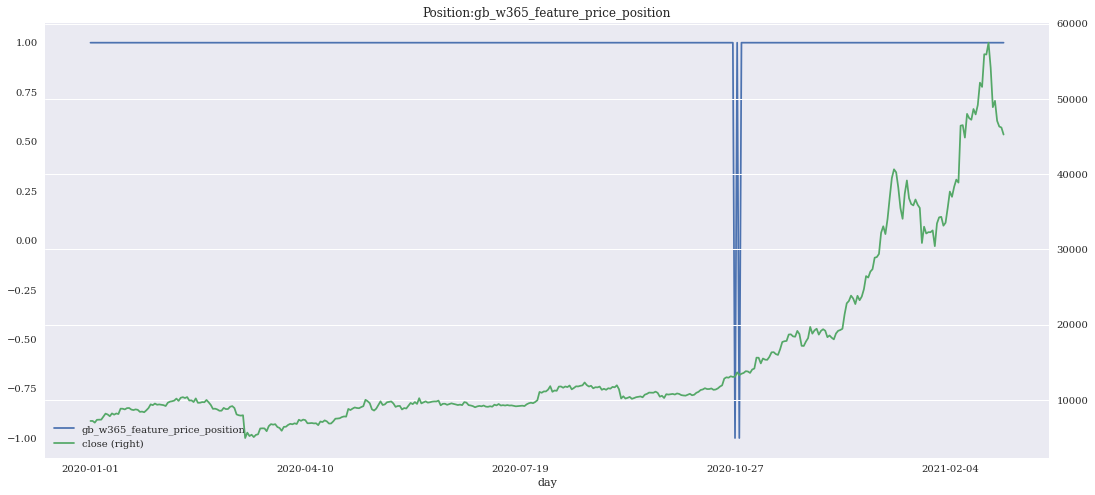

In [15]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp]
    ax = test_data[[kp+'_position','close']].plot(title='Position:'+kp+'_position',secondary_y='close',figsize=(18, 8))

### Feature Importance

In [17]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 265 (0.105373)
2. feature 269 (0.097602)
3. feature 360 (0.069876)
4. feature 195 (0.055588)
5. feature 106 (0.049044)
6. feature 315 (0.043266)
7. feature 154 (0.042956)
8. feature 185 (0.038671)
9. feature 112 (0.033723)
10. feature 144 (0.032423)
11. feature 356 (0.032339)
12. feature 205 (0.029220)
13. feature 136 (0.028496)
14. feature 153 (0.022825)
15. feature 167 (0.022722)
16. feature 54 (0.021124)
17. feature 10 (0.020799)
18. feature 255 (0.019427)
19. feature 310 (0.018966)
20. feature 152 (0.018765)
21. feature 26 (0.015283)
22. feature 292 (0.015011)
23. feature 220 (0.015006)
24. feature 237 (0.013090)
25. feature 3 (0.011662)
26. feature 135 (0.011582)
27. feature 215 (0.011300)
28. feature 156 (0.010628)
29. feature 29 (0.009726)
30. feature 303 (0.007518)
31. feature 290 (0.007097)
32. feature 125 (0.006795)
33. feature 55 (0.006722)
34. feature 253 (0.006308)
35. feature 181 (0.005711)
36. feature 361 (0.005140)
37. feature 110 (0.004484)
